In [24]:
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

In [10]:
df = pd.read_csv("data/dataset_final.csv")
df.head()

,Time,Temperature,Humidity,Air Quality,Light,Loudness
0,1623781306,37.94,28.94,75,644,106
1,1623781316,37.94,29.00,75,645,145
2,1623781326,37.88,28.88,75,644,146
3,1623781336,37.72,28.94,75,646,139
4,1623781346,37.69,29.19,75,644,155


# preprocessing 

In [11]:
df.dtypes

Time             int64
Temperature    float64
Humidity       float64
Air Quality      int64
Light            int64
Loudness         int64
dtype: object

In [12]:
df.columns

Index(['Time', 'Temperature', 'Humidity', 'Air Quality', 'Light', 'Loudness'], dtype='object')

In [13]:
df['Time'] = pd.to_datetime(df['Time'], unit='s')

# Set 'Time' column as index
df.set_index('Time', inplace=True)

# Display basic statistics of the dataset
df.head()

,Temperature,Humidity,Air Quality,Light,Loudness
Time,,,,,
2021-06-15 18:21:46,37.94,28.94,75,644,106
2021-06-15 18:21:56,37.94,29.00,75,645,145
2021-06-15 18:22:06,37.88,28.88,75,644,146
2021-06-15 18:22:16,37.72,28.94,75,646,139
2021-06-15 18:22:26,37.69,29.19,75,644,155


In [14]:
df.shape

(6558, 5)

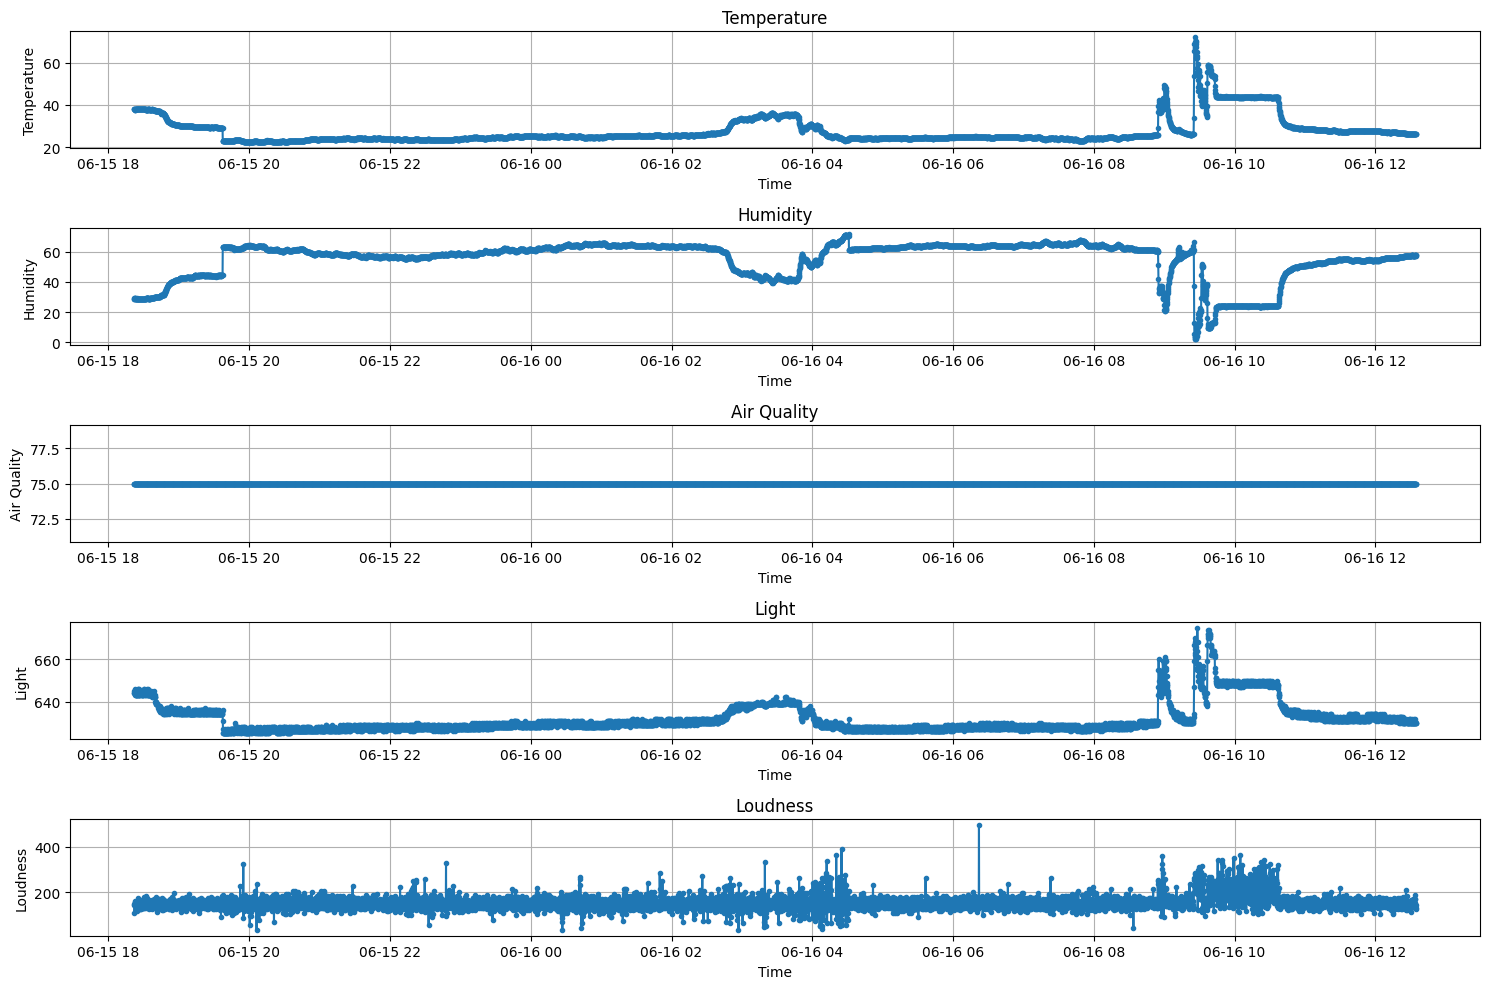

In [16]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i + 1)
    plt.plot(df.index, df[col], marker='.', linestyle='-')
    plt.title(col)
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(True)
plt.tight_layout()
plt.show()

# data normalization

In [18]:
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df.values)
df.head()

,Temperature,Humidity,Air Quality,Light,Loudness
Time,,,,,
2021-06-15 18:21:46,37.94,28.94,75,644,106
2021-06-15 18:21:56,37.94,29.00,75,645,145
2021-06-15 18:22:06,37.88,28.88,75,644,146
2021-06-15 18:22:16,37.72,28.94,75,646,139
2021-06-15 18:22:26,37.69,29.19,75,644,155


# create sequences

In [19]:
# Define sequence length
sequence_length = 10

# Create sequences of data
def create_sequences(data, sequence_length):
    X = []
    for i in range(len(data) - sequence_length + 1):
        X.append(data[i:i+sequence_length])
    return np.array(X)

# Create sequences for training
X_train = create_sequences(df_normalized, sequence_length)

In [21]:
# Split the normalized sequences into training and validation sets
X_train, X_val = train_test_split(X_train, test_size=0.2, shuffle=True, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)

Shape of X_train: (5239, 10, 5)
Shape of X_val: (1310, 10, 5)


In [22]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),  # Output only the last time step
    RepeatVector(X_train.shape[1]),  # Repeat the output across all time steps
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(X_train.shape[2])  # Output layer with the same number of features as input
])

# Compile the model
model.compile(loss='mse', optimizer='adam')  # Mean Squared Error loss

2024-09-10 16:00:12.429489: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/vidushee/downloads/IoT-sensor-data-anomaly-detection/iot_anomaly/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
history = model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val))

Epoch 1/50


2024-09-10 16:00:31.722385: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0322 - val_loss: 0.0017
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 9.8623e-04 - val_loss: 0.0011
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 9.2977e-04 - val_loss: 0.0011
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 9.4676e-04 - val_loss: 0.0012
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 9.6921e-04 - val_loss: 0.0011
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0010 - val_loss: 9.4708e-04
Epoch 12/50
164/164 ━━━━━━━━━━━

In [27]:
# Path to the directory and file
directory = '../artifacts'
filename = os.path.join(directory, 'model.pkl')

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the model
with open(filename, 'wb') as file:
    pickle.dump(model, file)